# A self-contained example of "the problem"

I produce here a simplified and self-contained example of the problem I encountered while trying to learn trapezoidal event by comparing membership function output. I consider here a trivial and perfect example: I want to define a model which takes as input the time signal of a trapezoidal event and outputs the 4 coefficients which describes it. Here I consider two approaches on the loss function:
1. I compare the membership function of the model output with the original signal. 
2. Extract the 4 coefficients from the signal through custom coefficients, hence compare these with model output.

The first option was the preferred one and the first I tried but I had some trouble learning the coefficients even in this perfect setting. I have spent some time on this, I may be likely blinded by some stubborn mistake. Whatever help on this matter is welcome and I thank in advance!

**Note**: It seems to be working now. There are three things which seem to be foundamental here:
1. Choice of the learning rate (I have to start high).
2. Choice of the number of points on which to subsample. This is something I had not done properly before (even if I was convinced about that).
3. Choice of the smooth version of membership function at first, the hard one to refine the model after it started to converge.

Probably there should be a custom policy to vary learning rate, number of subsampled points and beta parameter of the membership function from epoch to epoch. In fact, seems that low number of sampled points and high learning rate are important to start learning. Low learning rate and high number sampled points are beneficial at a later stage of training. 

I was not able to realize this before, and I couldn't learn anything at all, so I changed strategy. Now I may choose this first, which sounds also simpler and more elegant.

In [1]:
import numpy as np
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from tqdm.notebook import tqdm

# plotting
import matplotlib.pyplot as plt

Definition of the membership function:

In [2]:
max_events = 1
num_parameters = 4

def softplus(x, beta = 1.):
    return torch.nn.Softplus(beta)(x)

# params may contain multiple events (fixed to 1 here), it has shape (batch_size, num_events, num_params)
def membership_function(x, params, smooth = True, beta = 1.0):

    batch_size, num_sample_points = x.shape

    num_events = params.shape[1]
    assert batch_size == params.shape[0]
    assert num_parameters == params.shape[2]

    params = params.reshape(batch_size,1,num_events,4)
    x = x.view(batch_size,num_sample_points,1,1).repeat(1,1,num_events,1)

    a, b, c, d = params[:,:,:,[0]], params[:,:,:,[1]], params[:,:,:,[2]], params[:,:,:,[3]]

    if not smooth:
        res = torch.where(x<=a,0.,
            torch.where(x<=b, (x-a)/torch.clamp(b-a,1e-9), 
                torch.where(x<=c, 1.,
                    torch.where(x<=d,(x-d)/torch.clamp(c-d,max=-1e-9),0.)))) 
    else:
        beta = beta if beta is None else beta
        res = torch.where(x <= a, softplus(x-a, beta= beta),
            torch.where(x <= b, (x - a) / torch.clamp(b - a, min = 1e-9), 
                torch.where(x <= c, 1.-softplus(torch.max(b - x, x - c), beta),
                    torch.where(x <= d,(x - d) / torch.clamp(c - d, max = -1e-9), softplus(d-x, beta=beta)))))

    return res.sum(2).squeeze(-1)

Here below follows the dataloader. 

In [3]:
dummy_high = 200 

class TrapezoidalDataset(Dataset):
    
    def __init__(self, len_dataset, sequence_length = 100, min_events = 1, max_events = 5):
        
        self.len_dataset = len_dataset
        self.sequence_length = sequence_length
        self.max_events = max_events
        self.min_events = min_events
        self.seed = 42
        torch.manual_seed(self.seed)
        self.events = self.generate_events_sequence()
        self.x = torch.arange(self.sequence_length)
    
    def __len__(self):
        return self.len_dataset
    
    def generate_events(self, num_events):

        return torch.sort(self.sequence_length*torch.rand(size=(1,4*num_events))).values.view(num_events,4)
    
    def generate_events_sequence(self):

        num_events_list = torch.randint(self.min_events, self.max_events+1, (self.len_dataset,))
        #num_events_list = self.max_events*torch.ones(size = (self.len_dataset,), dtype = torch.int32)
        events = [self.generate_events(n) for n in num_events_list]

        return events
    
    def __getitem__(self, idx):
        
        y = self.events[idx]
        num_events = y.shape[0]
        x = torch.arange(self.sequence_length)
        
        X = membership_function(x[None], y[None], smooth=False).sum(axis=0)

        if num_events < self.max_events:
            y = torch.cat([y, dummy_high*torch.ones((self.max_events - num_events, 4))])

        return X, y
    
batch_size = 64

# We consider sequences of length 100
sequence_length = 100

# I set max_events to 1, so I will have exactly one event per sequence
trapezoidal_dataset = TrapezoidalDataset(10000, sequence_length = sequence_length, max_events = max_events)
trivial_dataloader = DataLoader(trapezoidal_dataset, batch_size=batch_size, shuffle=False)

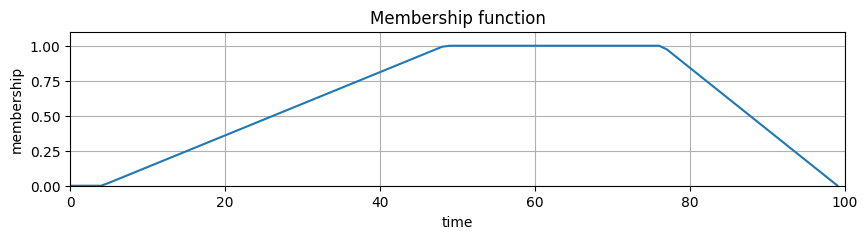

Coefficients:  [ 4.112273 48.333847 76.413246 99.03614 ]


In [4]:
# Example
X, y = trapezoidal_dataset[1]

fig, ax = plt.subplots(1,1,figsize=(10,2))
ax.plot(X)
ax.set_xlabel('time')
ax.set_ylabel('membership')
ax.set_title('Membership function')
ax.set_ylim(0,1.1)
ax.set_xlim(0,sequence_length)
ax.grid(True)
plt.show()

print("Coefficients: ", y.numpy().flatten())

### First model: standard MLP

We try first an MLP: input the time signal (input dim 100) output the four coefficients.

In [9]:
config = {"input_size" : sequence_length, "hidden_layers_size": [200,50], "output_size": 4*max_events}

class Model(nn.Module):

    # MLP with n hidden layer
    def __init__(self, config):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(config["input_size"], config["hidden_layers_size"][0]))

        for i in range(len(config["hidden_layers_size"]) - 1):
            self.layers.append(nn.Linear(config["hidden_layers_size"][i], config["hidden_layers_size"][i+1]))

        self.layers.append(nn.Linear(config["hidden_layers_size"][-1], config["output_size"]))
        self.activation = torch.nn.GELU()

        #self.dropout = nn.Dropout(config["dropout"])  # Add dropout layer

    def forward(self, x):

        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
            #x = self.dropout(x)  # Apply dropout

        x = torch.cumsum(torch.abs(self.layers[-1](x)), dim=-1)
        
        x = x.view( -1, max_events, 4)
        
        return x

model = Model(config)
#model.load_state_dict(torch.load('trapezoidal_event_mlp_trivial.pth'))

# print number of parameters
print("Number of parameters: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of parameters: 30454


In [6]:
#torch.save(model.state_dict(), 'trapezoidal_event_mlp_trivial.pth')

In [14]:
# Train the predicate
optimizer = optim.Adam(model.parameters(), lr = 0.01)
num_epochs = 10
criterion = torch.nn.MSELoss()

#criterion = torch.nn.BCELoss()
#criterion = torch.nn.L1Loss()
#criterion = torch.nn.HuberLoss()

num_sampling_points = 10 # number of points in which we sample the membership function for comparison

for epoch in tqdm(range(num_epochs)):

    losses = []
    
    for i, (X, y) in enumerate(trivial_dataloader):
        
        optimizer.zero_grad()

        x = torch.randint(0, 100, size = (y.shape[0], num_sampling_points))
        
        # Not subsampled version --> using the following line instead of the one above, it does not converge
        # x = torch.arange(0,100).repeat(y.shape[0],1)

        # We sample the membership function
        true_signal = membership_function(x, y)
        pred_signal = membership_function(x, model(X), smooth = True)

        loss = criterion(pred_signal, true_signal)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        tqdm.write("Epoch: {}/{}, Batch: {}/{}, Loss: {}".format(epoch+1, num_epochs, i, len(trivial_dataloader), np.mean(losses)), end="\r")

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

True coefficients: [11.83393  40.457855 46.145832 73.34265 ]
Predicted coefficients: [10.307341 40.22022  43.000954 76.90074 ]


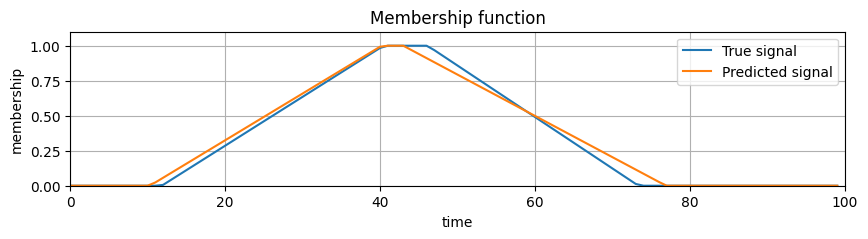

In [15]:
# Example
sample = 10 # Change to try other examples

X, y = trapezoidal_dataset[sample]

x = torch.arange(0,100)

fig, ax = plt.subplots(1,1,figsize=(10,2))
ax.plot(x, X, label = "True signal")

pred_params = model(X[None])

print("True coefficients: {}".format(y.squeeze().numpy()))
print("Predicted coefficients: {}".format(pred_params.squeeze().detach().numpy()))

predicted_signal = membership_function(x[None], pred_params, smooth=False).squeeze().detach()

ax.plot(predicted_signal, label = "Predicted signal")

ax.set_xlabel('time')
ax.set_ylabel('membership')
ax.set_title('Membership function')
ax.set_ylim(0,1.1)
ax.set_xlim(0,sequence_length)
ax.grid(True)
ax.legend()
plt.show()